# 1. Import Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
 
def open_json_data(fileLocation = 'train-1.json'):
    # Opening JSON file
    openFile = open(fileLocation)
    dictionary = json.load(openFile)
    # return pd.DataFrame(dictionary)[:10]
    return pd.DataFrame(dictionary)

# 2. Process data


In [2]:
def get_contribution_topic(data):
    return

In [3]:
def get_contribution_FieldOfStudy(data):
    return

## Dummy builders

### Get sparseDummies

### Get Dummies from single input

In [4]:
def dummy(data, dummy_column, delete_cat = True, spase= False):
    ## create dummy
    dummy = pd.get_dummies(data[dummy_column],prefix=dummy_column, drop_first=True, sparse=spase)
    print('dummy', dummy.shape)
    data = pd.concat([data, dummy], axis=1)
    ## drop the original categorical column
    if delete_cat : return data.drop(dummy_column, axis=1)
    return data

### Get Dummies from list

In [5]:
def dummies_from_nestedList(data, dummy_column):
    ## create dummy
    print(data)
    dummy = pd.get_dummies(data[dummy_column, 1].apply(pd.Series).stack()).sum(level=0)
    print('dummy', dummy.shape)
    data = pd.concat([data, dummy], axis=1)
    ## drop the original categorical column
    # if delete_cat : return data.drop(dummy_column, axis=1)
    return data

## Year Data

### Adding the categorical years


In [6]:
def get_years(data, return_with_dummy= False):
    conditions = [
        (data['year'] < 2000),
        (data['year'] >= 2000) & (data['year'] <= 2010),
        (data['year'] > 2010) & (data['year'] < 2016),
        (data['year'] >= 2016)
    ]
    values = [1, 2, 3, 4]
    data['class_year'] = np.select(conditions, values)
    if return_with_dummy : return dummy(data,"class_year")
    return data

## References

### Adding Categorical References

In [7]:
def get_ref(file, return_with_dummy= False):
    conditions = [
        (file['references'] == 0),
        (file['references'] > 0) & (file['references'] <= 30),
        (file['references'] > 30) & (file['references'] < 60),
        (file['references'] >= 60)
    ]
    values = [1, 2, 3, 4]
    file['class_ref'] = np.select(conditions, values)
    if return_with_dummy : return dummy(file,"class_ref")
    return file

## Fill Nan

In [8]:
# def fill_Nan(data):
#     for column in data:
#         if data[column].dtype == np.float64 or data[column].dtype == np.int64:data[column].fillna(data[column].mean())
#     return data
def fill_Nan(data):
    data['year'] = data['year'].fillna(data['references'].mean())
    data['references'] = data['references'].fillna(0)
    data["fields_of_study"] = data["fields_of_study"].fillna("")
    data["title"] = data["title"].fillna("")
    return data

### Title length


In [10]:
def get_titleLen(data):
    data["title_len"] = data.apply(lambda x:len(x["title"]),axis=1)
    return data

### Authors length

In [11]:
def get_AuthorsLen(data):
    data["authors_len"] = data.apply(lambda x:len(x["authors"]),axis=1)
    return data

### Topics Length

In [12]:
def get_TopicsLen(data):
    data["topics_len"] = data.apply(lambda x:len(x["topics"]),axis=1)
    return data

### Fields of Study Length

In [13]:
def get_FieldsOfStudyLen(data):
    data["fields_of_study_len"] = data.apply(lambda x:len(x["fields_of_study"]),axis=1)
    return data

### Find venue data

In [14]:
def find_venue_in_dataFrame(venue, venues_dict):
    venue_cat = venues_dict[venues_dict["venue"].str.decode("utf-8")  == venue]
    if len(venue_cat)>0 : return venue_cat.iloc[0]['class_Venue']
    return 0

def get_venue(data):
    venue_dictionary = pd.read_pickle("venue_data.pkl")
    data["venue_cat"] = data.apply(lambda x:find_venue_in_dataFrame(x.venue, venue_dictionary),axis=1)
    return data


# Plot line

## Plot single line

In [15]:
import matplotlib.pyplot as plt
def plotY(Y):
    Y = np.array(Y)
    Y = np.sort(Y)
    plt.plot(Y)
    return plt.show()

## Plot 2 lines

In [16]:
import matplotlib.pyplot as plt
def plotY2(Ypred,Yreal):
    length = len(Ypred)
    plt.plot(Yreal,'b')
    plt.plot(Ypred,'r')
    return plt.show()

# Model

## Data preprocessing

In [21]:
def process_data(data):
    data = fill_Nan(data)
    data = get_ref(data, True)
    data = get_years(data, True)    
    data = get_titleLen(data)
    data = get_FieldsOfStudyLen(data)
    data = data.assign(authorsLen2 = lambda x: x['fields_of_study_len'] * x['fields_of_study_len'])
    data = data.assign(authorsLen3 = lambda x: x['fields_of_study_len'] * x['fields_of_study_len'] * x['fields_of_study_len'])
    data = get_TopicsLen(data)
    data = data.assign(authorsLen2 = lambda x: x['topics_len'] * x['topics_len'])
    data = data.assign(authorsLen3 = lambda x: x['topics_len'] * x['topics_len'] * x['topics_len'])
    data = get_AuthorsLen(data)
    data = data.assign(authorsLen2 = lambda x: x['authors_len'] * x['authors_len'])
    data = data.assign(authorsLen3 = lambda x: x['authors_len'] * x['authors_len'] * x['authors_len'])
    return data

## Evaluation

In [9]:
from sklearn import metrics

def eval(predicted, y_test):
    ## Kpi
    print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test - predicted) / predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
            "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
    ## residuals
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(
        residuals).index(min(residuals))
    # max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    return(residuals,max_error,max_idx)

# Throw everthing together
The function will consist of two steps, first the program will load all the data and process this. This is necessary in order to know the relative contribution of different variables. Then it will split the data file in two sections, train and test in order to know the respective progress of the learning task.

In [40]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
# from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from sklearn import linear_model

def model():
    
    data = open_json_data()
    
    data = fill_Nan(data)
    data = get_ref(data, True)
    data = get_years(data, True)    
    data = get_titleLen(data)
    data = get_FieldsOfStudyLen(data)
    data = get_TopicsLen(data)
    data = get_AuthorsLen(data)
    
    data = data.assign(fields_of_study_len2 = lambda x: x['fields_of_study_len'] * x['fields_of_study_len'])
    data = data.assign(fields_of_study_len3 = lambda x: x['fields_of_study_len'] * x['fields_of_study_len'] * x['fields_of_study_len'])
    data = data.assign(topicsLen2 = lambda x: x['topics_len'] * x['topics_len'])
    data = data.assign(topicsLen3 = lambda x: x['topics_len'] * x['topics_len'] * x['topics_len'])
    data = data.assign(topicsLen4 = lambda x: x['topics_len'] * x['topics_len'] * x['topics_len']* x['topics_len'])
    data = data.assign(topicsLen5 = lambda x: x['topics_len'] * x['topics_len'] * x['topics_len']* x['topics_len']* x['topics_len'])
    data = data.assign(authorsLen2 = lambda x: x['authors_len'] * x['authors_len'])
    data = data.assign(authorsLen3 = lambda x: x['authors_len'] * x['authors_len'] * x['authors_len'])
    data = data.assign(topicsFoS = lambda x: x['topics_len'] * x['fields_of_study_len'])
    
    print(data.shape)
        
    X = data.drop(["citations", "year", "doi", "title", "abstract", "authors", "topics","fields_of_study", "venue"], axis=1).values
    y = data["citations"].values

    # plotY(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=2021)
    # model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=10000, tol=1e-3))
    # model = make_pipeline(StandardScaler(), linear_model.Ridge(alpha=1.1))
    model = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=1.1, selection='random'))
    # model = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=2, random_state=0))
    # model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2,degree=2))

    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    predictions = model.predict(X_val)

    Ypred = np.array(predictions)
    Ypred = np.sort(predictions)
    Yreal = np.array(y_val)
    Yreal = np.sort(y_val)
    # plotY(Ypred)
    # plotY2(Ypred, Yreal)

    print(Ypred)
    print(Yreal)
    print(eval(Ypred[:-100], Yreal[:-100]))
    print(score)
    # print(score(y_val, predictions))
    # print(model.score(X_val, y_val))
    return 
    # huber = HuberRegressor().fit(X_train, y_train)
    # print(huber.score(X_val, y_val))

    # linear = LinearRegression()
    # linear.fit(X_train, y_train)
    # print(linear.score(X_val,y_val))

    # return model
    # return model.score(X_val, y_val)
    # return predictions
    # return model.fit(X_train, y_train).score(X_val, y_val)
    
    # return cross_val_score(model, X, y, cv=10)
    # cross_val_score(model, X, y, cv=10)
    # return cross_val_score(model, X, y, cv=10)

model()

dummy (9658, 3)
dummy (9658, 3)
(9658, 31)
[-42.87578967 -30.83423084 -30.61915482 ... 271.90041362 287.24348446
 329.89917235]
[   0    0    0 ... 2887 3610 6764]
R2 (explained variance): 0.62
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.67
Mean Absolute Error (Σ|y-pred|/n): 17
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 19
Max Error: 87
(array([42.87578967, 30.83423084, 30.61915482, ..., 84.47994865,
       87.42824743, 86.89832411]), 87.42824742976137, 3086)
0.019398206477996283


## Test model

(9658, 17)
(1000, 16)


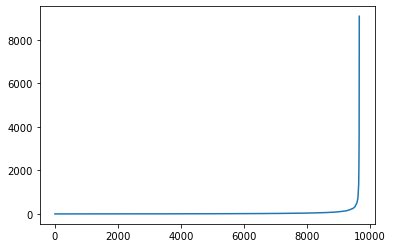

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    3    4    4    6   17   20
   22   26   29   33   40   43   43   48   49   50   52   54   54   56
   57   58   58   61   65   67   68   70   72   75   77   78   80   82
   82   83   83   83   85   86   88   90   91   91   91   92   93   96
   97   98   99  100  100  101  102  103  104  104  107  108  108  109
  110  110  112  112  113  113  114  114  115  115  115  116  117  117
  118  119  119  120  120  120  120  121  121  121  122  122  122  122
  123  123  123  124  124  125  125  126  126  127  127  127  128  130
  131  131  131  131  132  132  133  133  133  133  134  135  136  136
  137  138  139  140  140  140  140  141  143  143  145  145  145  145
  145  146  146  146  146  149  149  149  151  151  151  151  151  152
  152  153  153  153  154  155  155  155  156  156  156  157  158  158
  158  158  159  159  160  160  161  161  161  161  161  161  162  162
  162 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from sklearn import linear_model

def model():
    
    data = open_json_data()
    data = fill_Nan(data)
    data = get_ref(data, False)
    data = get_years(data, False)    
    data = get_titleLen(data)
    data = get_FieldsOfStudyLen(data)
    data = get_TopicsLen(data)
    data = get_AuthorsLen(data)
    
    print(data.shape)

    data_test = open_json_data('test.json')
    data_test = fill_Nan(data_test)
    data_test = get_ref(data_test, False)
    data_test = get_years(data_test, False)    
    data_test = get_titleLen(data_test)
    data_test = get_FieldsOfStudyLen(data_test)
    data_test = get_TopicsLen(data_test)
    data_test = get_AuthorsLen(data_test)

    print(data_test.shape)

    
    X_train = data.drop(["citations", "year", "doi", "title", "abstract", "authors", "topics","fields_of_study", "venue"], axis=1).values
    y_train = data["citations"].values
    plotY(y_train)

    X_test = data_test.drop(["year", "doi", "title", "abstract", "authors", "topics","fields_of_study", "venue"], axis=1).values

    model = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=1.1))

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    
    Ypred = pd.Series(predictions.astype(int))
    Ypred = Ypred.where(Ypred > 0, 0)
    
    data_test["citations"] = predictions.astype('int') 
    
    # Ypred = np.array(Ypred)
    YpredSorted = np.sort(Ypred)
    print(YpredSorted)

    
    return data_test

model().to_json("output.json", orient='records')